In [2]:
import os
import torch
import spectral
import time
import collections
import torch.nn as nn
import torch.nn.functional as F 
import torchvision
from tqdm import tqdm
from arguments import get_args
from augmentations import get_aug
from models import get_model, get_backbone
from tools import AverageMeter
from optimizers import get_optimizer, LR_Scheduler
import sys
sys.path.append('./global_module/')
import network

import train
from generate_pic import aa_and_each_accuracy, sampling,load_dataset, generate_png1, generate_iter
from sklearn.model_selection import train_test_split
from Utils import record, extract_samll_cubic
import datetime
import numpy as np
from sklearn import metrics, preprocessing
from torch import optim
from sklearn.decomposition import PCA
from vit import ViT
import pickle
from collections import defaultdict
import sklearn
from sklearn import metrics

ModuleNotFoundError: No module named 'torchtext'

In [3]:
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
def generate_iter_ViT(perclass, randomseed,total_indices, 
                  whole_data, PATCH_LENGTH, padded_data, INPUT_DIMENSION, batch_size, gt,args=None):

    gt_all = gt[total_indices] - 1


    if randomseed:
        randomState=345
    else:
        randomState=int(np.random.randint(1, high=1000))

    all_data=extract_samll_cubic.select_small_cubic(TOTAL_SIZE, total_indices, whole_data,
                                                       PATCH_LENGTH, padded_data, INPUT_DIMENSION)
    x_all=all_data
    
    x_test_all,x_train,y_test_all,y_train=train_test_split(x_all,gt_all, test_size=perclass,random_state=randomState,stratify=gt_all)
    
    #print(x_test_all.shape,y_test_all.shape)
    print(x_train.shape,y_train.shape)

    
    x1_tensor_train = torch.from_numpy(x_train).type(torch.FloatTensor).permute(0,3,1,2)
    y1_tensor_train = torch.from_numpy(y_train).type(torch.FloatTensor)
    torch_dataset_train = Data.TensorDataset(x1_tensor_train, y1_tensor_train)

    x1_tensor_test = torch.from_numpy(x_test_all).type(torch.FloatTensor).permute(0,3,1,2)
    y1_tensor_test = torch.from_numpy(y_test_all).type(torch.FloatTensor)
    torch_dataset_test = Data.TensorDataset(x1_tensor_test,y1_tensor_test)

    x1_tensor_all = torch.from_numpy(x_all).type(torch.FloatTensor).permute(0,3,1,2)
    y1_tensor_all = torch.from_numpy(gt_all).type(torch.FloatTensor)
    torch_dataset_all = Data.TensorDataset(x1_tensor_all,y1_tensor_all)

    if args!=None:
        train_iter = Data.DataLoader(
            dataset=torch_dataset_train,  # torch TensorDataset format
            batch_size=batch_size,  # mini batch size
            sampler=FastRandomIdentitySampler(torch_dataset_train, num_instances=args.num_instances),
            shuffle=False,  # 要不要打乱数据 (打乱比较好)
            num_workers=0,  # 多线程来读数据
        )
    else:
        train_iter = Data.DataLoader(
            dataset=torch_dataset_train,  # torch TensorDataset format
            batch_size=batch_size,  # mini batch size
            shuffle=True,  # 要不要打乱数据 (打乱比较好)
            num_workers=0,  # 多线程来读数据
        )
    test_iter = Data.DataLoader(
        dataset=torch_dataset_test,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=False,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多线程来读数据
    )
    all_iter = Data.DataLoader(
        dataset=torch_dataset_all,  # torch TensorDataset format
        batch_size=batch_size,  # mini batch size
        shuffle=False,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多线程来读数据
    )
    return train_iter, test_iter, all_iter#, y_test

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
class svm_rbf():
    def __init__(self, data, label):
        self.name = 'SVM_RBF'
        self.trainx = data
        self.trainy = label
    '''
    def train(self):
        cost = []
        gamma = []
        for i in range(-3, 10, 2):
            cost.append(np.power(2.0, i))
        for i in range(-5, 4, 2):
            gamma.append(np.power(2.0, i))
    
        parameters = {'C': cost, 'gamma': gamma}
        svm = SVC(verbose=0, kernel='rbf')
        clf = GridSearchCV(svm, parameters, cv=3)
        clf.fit(self.trainx, self.trainy)
    
        # print(clf.best_params_)
        bestc = clf.best_params_['C']
        bestg = clf.best_params_['gamma']
        tmpc = [-1.75, -1.5, -1.25, -1, -0.75, -0.5, -0.25, 0.0,
                0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
        cost = []
        gamma = []
        for i in tmpc:
            cost.append(bestc * np.power(2.0, i))
            gamma.append(bestg * np.power(2.0, i))
        parameters = {'C': cost, 'gamma': gamma}
        svm = SVC(verbose=0, kernel='rbf')
        clf = GridSearchCV(svm, parameters, cv=3)
        clf.fit(self.trainx, self.trainy)
        print(clf.best_params_)
        p = clf.best_estimator_
        return p
    '''
    def train(self):
        SVM_GRID_PARAMS = [
        {'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1], 'C': [0.1, 1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
        {'kernel': ['poly'], 'degree': [3], 'gamma': [1e-1, 1e-2, 1e-3]}
    ]
        class_weight = 'balanced'
        clf = sklearn.svm.SVC(class_weight=class_weight,probability=True,gamma='scale',kernel='linear')
        clf = sklearn.model_selection.GridSearchCV(clf, SVM_GRID_PARAMS, scoring=None, n_jobs=-1, iid=True,
                                              refit=True, cv=3, verbose=3, pre_dispatch='2*n_jobs',
                                              error_score='raise', return_train_score=True)
        clf.fit(self.trainx, self.trainy)
        print(clf.best_params_)
        return clf


In [5]:
def inference(loader, model, device):
    feature_vector = []
    labels_vector = []
    model.eval()
    for step, (x, y) in enumerate(loader):
        #print('x',x.shape,'y',y.shape)
        
        x = x.to(device)
        
        # get encoding
        with torch.no_grad():
            h = model(x)
        #print('h',h.shape)
        #h = h.squeeze()
        #print('h',h.shape)
        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 5 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector


def get_features(model, train_loader, test_loader, all_loader,device):
    train_X, train_y = inference(train_loader, model, device)
    test_X, test_y = inference(test_loader, model, device) 
    all_x,all_y= inference(all_loader, model, device)
    return train_X, train_y, test_X, test_y,all_x,all_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=True
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

In [6]:
def applyPCA(src,components=15):
    
    pc = spectral.principal_components(src)
    pc_98 = pc.reduce(fraction=0.98)  # 保留98%的特征值
    # print(len(pc_98.eigenvalues))  # 剩下的特征值数量
    # spy.imshow(data=pc.cov, title="pc_cov")
    img_pc = pc_98.transform(src)  # 把数据转换到主成分空间
    new_pca_dataset = img_pc[:, :, :components]
    
    return new_pca_dataset

In [7]:
import argparse
dataset_names = ['IN','SV','UP']
parser = argparse.ArgumentParser(description="Run deep learning experiments on"
                                             " various hyperspectral datasets")
parser.add_argument('--dataset', type=str, default='SV', choices=dataset_names,
                    help="Dataset to use.")
parser.add_argument('--train',type=int, default=0,choices=(0,1))
parser.add_argument('--perclass', type=float, default=5) #要除以100,百分之多少
parser.add_argument('--device', type=str, default="cuda:0", choices=("cuda:0","cuda:1"))
parser.add_argument('--batch_size', type=int, default=1024)
parser.add_argument('--patch_length', type=int, default=13)
parser.add_argument('--classifier', type=str, default='svm',choices=("linear","svm"))
parser.add_argument('--train_contrast',type=int, default=0,choices=(0,1))
parser.add_argument('--Patch_channel', type=int, default=15)#PCA降低的维数
parser.add_argument('--iter_num', type=int, default=1)#跑几次
parser.add_argument('--RandomSeed', type=bool, default=False)#是否固定划分训练集和测试集,false就不固定

args = parser.parse_args(args=[])
args.perclass=args.perclass/100
print(args)
device = torch.device(args.device)
day = datetime.datetime.now()
day_str = day.strftime('%m_%d_%H_%M')

print('-----Importing Dataset-----')
global Dataset  # UP,IN,KSC
dataset=args.dataset
Dataset = dataset.upper()
data_hsi, gt_hsi, TOTAL_SIZE, TRAIN_SIZE, VALIDATION_SPLIT = load_dataset(Dataset)



Namespace(Patch_channel=15, RandomSeed=False, batch_size=1024, classifier='svm', dataset='SV', device='cuda:0', iter_num=1, patch_length=13, perclass=0.05, train=0, train_contrast=0)
-----Importing Dataset-----


In [11]:
#PCA降维维数
data_hsi=applyPCA(data_hsi,args.Patch_channel)
print(data_hsi.shape)
image_x, image_y, BAND = data_hsi.shape
data = data_hsi.reshape(np.prod(data_hsi.shape[:2]), np.prod(data_hsi.shape[2:]))
gt = gt_hsi.reshape(np.prod(gt_hsi.shape[:2]),)
CLASSES_NUM = max(gt)
print('The class numbers of the HSI data is:', CLASSES_NUM)

print('-----Importing Setting Parameters-----')
ITER = args.iter_num
PATCH_LENGTH = args.patch_length
# number of training samples per class
#lr, num_epochs, batch_size = 0.0010, 200, 32#3e-3
lr, num_epochs, batch_size = 0.005, 3000000, 256


img_rows = 2*PATCH_LENGTH+1
img_cols = 2*PATCH_LENGTH+1
img_channels = data_hsi.shape[2]
INPUT_DIMENSION = data_hsi.shape[2]
ALL_SIZE = data_hsi.shape[0] * data_hsi.shape[1]#并不对，因为有部分像素点对应标签为背景


KAPPA = []
OA = []
AA = []
TRAINING_TIME = []
TESTING_TIME = []
ELEMENT_ACC = np.zeros((ITER, CLASSES_NUM))

data = preprocessing.scale(data)
data_ = data.reshape(data_hsi.shape[0], data_hsi.shape[1], data_hsi.shape[2])
whole_data = data_
padded_data = np.lib.pad(whole_data, ((PATCH_LENGTH, PATCH_LENGTH), (PATCH_LENGTH, PATCH_LENGTH), (0, 0)),
                         'constant', constant_values=0)

(512, 217, 2)
The class numbers of the HSI data is: 16
-----Importing Setting Parameters-----


In [12]:
model=ViT(image_size = PATCH_LENGTH*2+1,patch_size = 3,dim = 256,depth = 2,heads = 16,mlp_dim =512,
                  pool = 'cls', channels = BAND, dim_head = 32,dropout = 0.,emb_dropout = 0.,device=device) 

In [13]:
#SVM画图
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')
def classification_map(map, ground_truth, dpi, save_path):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(ground_truth.shape[0]/20, ground_truth.shape[1]/20)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    #plt.axis('off')
    ax.set_axis_off()
    ax.axis('off')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    #plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
    #plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
    #plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
    ax.imshow(map)
    plt.show()
    fig.savefig(save_path)
    plt.close()

    return 0


def list_to_colormap(x_list):
    y = np.zeros((x_list.shape[0], 3))
    
    for index, item in enumerate(x_list):
        #print(index,'  ',item)
        if item == 0:
            y[index] = np.array([230, 0, 0]) / 255.
        if item == 1:
            y[index] = np.array([235, 97, 0]) / 255.
        if item == 2:
            y[index] = np.array([243, 152, 0]) / 255.
        if item == 3:
            y[index] = np.array([252, 200, 0]) / 255.
            #y[index] = np.array([215, 255, 0]) / 255.
        if item == 4:
            y[index] = np.array([255, 251, 0]) / 255.
        if item == 5:
            y[index] = np.array([207, 0, 219]) / 255.
        if item == 6:
            y[index] = np.array([143, 195, 31]) / 255.
        if item == 7:
            y[index] = np.array([0, 153, 68]) / 255.
        if item == 8:
            y[index] = np.array([0, 158, 150]) / 255.
        if item == 9:
            y[index] = np.array([64,69,178]) / 255.
        if item == 10:
            y[index] = np.array([0, 134, 209]) / 255.
        if item == 11:
            y[index] = np.array([0, 71, 157]) / 255.
        if item == 12:
            y[index] = np.array([29,32,136]) / 255.
        if item == 13:
            y[index] = np.array([146,7,131]) / 255.
        if item == 14:
            y[index] = np.array([190,0,129]) / 255.
        if item == 15:
            y[index] = np.array([229,0,106]) / 255.
        if item == 16:
            y[index] = np.array([0,0,0]) / 255.
        if item == -1:
            y[index] = np.array([0, 0, 0]) / 255.
    return y
def generate_png(all_X, net, gt_hsi, Dataset, device, total_indices):
    pred_test = []
    # with torch.no_grad():
    #     for i in range(len(gt_hsi)):
    #         if i == 0:
    #             pred_test.extend([-1])
    #         else:
    #             X = all_iter[i].to(device)
    #             net.eval()  # 评估模式, 这会关闭dropout
    #             # print(net(X))
    #             pred_test.extend(np.array(net(X).cpu().argmax(axis=1)))

        # for X, y in all_iter:
        #     #for data, label in X, y:
        #     if y.item() != 0:
        #         # print(X)
        #         X = X.to(device)
        #         net.eval()  # 评估模式, 这会关闭dropout
        #         y_hat = net(X)
        #         # print(net(X))
        #         pred_test.extend(np.array(net(X).cpu().argmax(axis=1)))
        #     else:
        #         pred_test.extend([-1])
    with torch.no_grad():
        for i in range(all_X.shape[0]):   
            outputs = net.predict(all_X[i:i+1])
            pred_test.extend(outputs)

    gt = gt_hsi.flatten()
    x_label = np.zeros(gt.shape)
    for i in range(len(gt)):
        if gt[i] == 0:
            gt[i] = 17
            # x[i] = 16
            x_label[i] = 16
        # else:
        #     x_label[i] = pred_test[label_list]
        #     label_list += 1
    gt = gt[:] - 1
    x_label[total_indices] = pred_test
    x = np.ravel(x_label)

    # print('-------Save the result in mat format--------')
    # x_re = np.reshape(x, (gt_hsi.shape[0], gt_hsi.shape[1]))
    # sio.savemat('mat/' + Dataset + '_' + '.mat', {Dataset: x_re})

    y_list = list_to_colormap(x)
    print("Start getting classification maps")
    y_gt = list_to_colormap(gt)
    print("Start getting label maps")

    y_re = np.reshape(y_list, (gt_hsi.shape[0], gt_hsi.shape[1], 3))
    gt_re = np.reshape(y_gt, (gt_hsi.shape[0], gt_hsi.shape[1], 3))

    path = './' + 'byolSVM'
    classification_map(y_re, gt_hsi, 300,
                       path + '/classification_maps/' + Dataset + '_' + 'byolSVM' +  '.png')
    classification_map(gt_re, gt_hsi, 300,
                       path + '/classification_maps/' + Dataset + '_gt.png')
    print('------Get classification maps successful-------')

In [14]:
#打印结果
def print_output(oa_ae, aa_ae, kappa_ae, element_acc_ae, training_time_ae, testing_time_ae):
    sentence0 = 'OAs for each iteration are:' + str(oa_ae) + '\n'
    print(sentence0)
    sentence1 = 'AAs for each iteration are:' + str(aa_ae) + '\n'
    print(sentence1)
    sentence2 = 'KAPPAs for each iteration are:' + str(kappa_ae) + '\n' + '\n'
    print(sentence2)
    sentence3 = 'mean_OA ± std_OA is: ' + str(np.mean(oa_ae)) + ' ± ' + str(np.std(oa_ae)) + '\n'
    print(sentence3)
    sentence4 = 'mean_AA ± std_AA is: ' + str(np.mean(aa_ae)) + ' ± ' + str(np.std(aa_ae)) + '\n'
    print(sentence4)
    sentence5 = 'mean_KAPPA ± std_KAPPA is: ' + str(np.mean(kappa_ae)) + ' ± ' + str(np.std(kappa_ae)) + '\n' + '\n'
    print(sentence5)
    sentence6 = 'Total average Training time is: ' + str(np.sum(training_time_ae)) + '\n'
    print(sentence6)
    sentence7 = 'Total average Testing time is: ' + str(np.sum(testing_time_ae)) + '\n' + '\n'
    print(sentence7)
    element_mean = np.mean(element_acc_ae, axis=0)
    element_std = np.std(element_acc_ae, axis=0)
    sentence8 = "Mean of all elements in confusion matrix: " + str(element_mean) + '\n'
    print(sentence8)
    sentence9 = "Standard deviation of all elements in confusion matrix: " + str(element_std) + '\n'
    print(sentence9)

In [15]:
for index_iter in range(ITER):
    print('iter:', index_iter)
    #net = network.FDSSC_network(BAND, CLASSES_NUM)
        # define model
    
    _, total_indices = sampling(1, gt)
    print('-----Selecting Small Pieces from the Original Cube Data-----')

    train_iter, test_iter,all_iter = generate_iter_ViT(args.perclass,args.RandomSeed,total_indices,
                  whole_data, PATCH_LENGTH, padded_data, INPUT_DIMENSION, batch_size, gt)
    
    
    train_num=[0]*17
    for k,(x,y) in enumerate(train_iter):
        #input_dim=x.shape[1:]
        print('train_iter shape:',x.shape)
        break
        #print(y,y.shape)
    for k,(x,y) in enumerate(train_iter):
        for num1 in y:
            #print(num1)
            train_num[num1.int()]+=1
    print("train_num：",train_num)
    test_num=[0]*17
    for k,(x,y) in enumerate(test_iter):
        for num3 in y:
            test_num[num3.int()]+=1
    print("test_num",test_num)
    print('训练集总和:',sum(train_num))
    print('测试集总和:',sum(test_num))
    
    model.load_state_dict(torch.load('./results/byolsv_0929100518_epoch2.pt'))
    
    #num_features = list(model.children())[-1].out_features
    num_features = 128
    # throw away fc layer
    #model = nn.Sequential(*list(model.children())[:-1])
    #print(model)
    model=model.to(device)
    n_classes = CLASSES_NUM 
    # fine-tune model
    logreg = nn.Sequential(nn.Linear(num_features, n_classes))
    logreg = logreg.to(device)
    

    # loss / optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=logreg.parameters(), lr=lr)

    # compute features (only needs to be done once, since it does not backprop during fine-tuning)
    #取消读取上一次的结果
    '''
    if not os.path.exists("features.p"):
        print("### Creating features from pre-trained model ###")
        (train_X, train_y, test_X, test_y,all_x,all_y) = get_features(model, train_iter, test_iter, all_iter,device)
        pickle.dump(
            (train_X, train_y, test_X, test_y,all_x,all_y), open("features.p", "wb"), protocol=4
        )
    else:
        print("### Loading features ###")
        (train_X, train_y, test_X, test_y,all_x,all_y) = pickle.load(open("features.p", "rb"))
    '''
    print("### Creating features from pre-trained model ###")
    (train_X, train_y, test_X, test_y,all_x,all_y) = get_features(model, train_iter, test_iter, all_iter,device)
    pickle.dump(
    (train_X, train_y, test_X, test_y,all_x,all_y), open("features.p", "wb"), protocol=4
    )
    '''

    train_loader, test_loader = create_data_loaders_from_arrays(
        train_X, train_y, test_X, test_y, 2048 
    )

    # Train fine-tuned model
    
    for epoch in range(num_epochs):
        metrics = defaultdict(list)
        for step, (h, y) in enumerate(train_loader):
            h = h.to(device)
            y = y.to(device)
            
            outputs = logreg(h)
            #print(outputs.shape,y.shape)
            loss = criterion(outputs, y.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy and save metrics
            accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0)
            metrics["Loss/train"].append(loss.item())
            metrics["Accuracy/train"].append(accuracy)

        if epoch%100==0:
            print(f"Epoch [{epoch}/{num_epochs}]: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()]))


    # Test fine-tuned model
        #print("### Calculating final testing performance ###")
        metrics = defaultdict(list)
        for step, (h, y) in enumerate(test_loader):
            h = h.to(device)
            y = y.to(device)

            outputs = logreg(h)

        # calculate accuracy and save metrics
            accuracy = (outputs.argmax(1) == y).sum().item() / y.size(0)
            #print('accauracy on test:',accuracy)
            metrics["Accuracy/test"].append(accuracy)

        if epoch%100==0:
            print(f"Final test performance: " + "\t".join([f"{k}: {np.array(v).mean()}" for k, v in metrics.items()]))
    '''
    print('training SVM')
    print(train_X.shape,test_X.shape)
    print(train_y.shape,test_y.shape)
    print(all_x.shape,all_y.shape)
    tic1 = time.clock()
    net=svm_rbf(train_X,train_y)
    svm_test=net.train()
    toc1 = time.clock()
    print('SVM training ended')
    # Test fine-tuned model
    #print("### Calculating final testing performance ###")
    pred_test=[]
    tic2 = time.clock()
    with torch.no_grad():
        for i in range(test_X.shape[0]):   
            outputs = svm_test.predict(test_X[i:i+1])
            pred_test.extend(outputs)
    
    toc2 = time.clock()
    collections.Counter(pred_test)
    
    overall_acc_fdssc = metrics.accuracy_score(pred_test, test_y)
    confusion_matrix_fdssc = metrics.confusion_matrix(pred_test, test_y)
    each_acc_fdssc, average_acc_fdssc = aa_and_each_accuracy(confusion_matrix_fdssc)
    kappa = metrics.cohen_kappa_score(pred_test, test_y)
    KAPPA.append(kappa)
    OA.append(overall_acc_fdssc)
    AA.append(average_acc_fdssc)
    TRAINING_TIME.append(toc1 - tic1)
    TESTING_TIME.append(toc2 - tic2)
    ELEMENT_ACC[index_iter, :] = each_acc_fdssc
    print(overall_acc_fdssc)
    generate_png(all_x, svm_test, gt_hsi, Dataset, device, total_indices)
    print_output(OA,AA,KAPPA,ELEMENT_ACC,TRAINING_TIME,TESTING_TIME)
    print(confusion_matrix_fdssc)

iter: 0
-----Selecting Small Pieces from the Original Cube Data-----
(2707, 27, 27, 2) (2707,)
train_iter shape: torch.Size([256, 2, 27, 27])
train_num： [100, 186, 99, 70, 134, 198, 179, 564, 310, 164, 53, 96, 46, 54, 364, 90, 0]
test_num [1909, 3540, 1877, 1324, 2544, 3761, 3400, 10707, 5893, 3114, 1015, 1831, 870, 1016, 6904, 1717, 0]
训练集总和: 2707
测试集总和: 51422


FileNotFoundError: [Errno 2] No such file or directory: './results/byolsv_0929100518_epoch2.pt'

Start getting classification maps
Start getting label maps


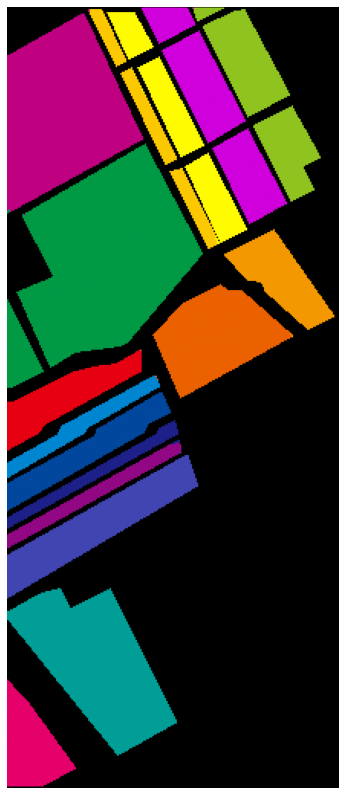

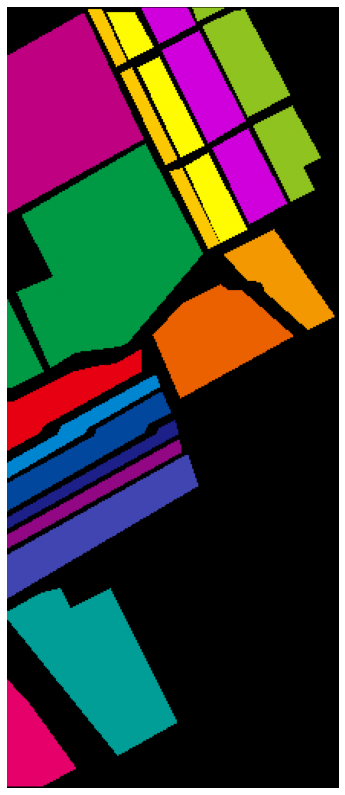

------Get classification maps successful-------


In [12]:
generate_png(all_x, svm_test, gt_hsi, Dataset, device, total_indices)

In [13]:
print(confusion_matrix_fdssc)

[[ 1908     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    1  3537     0     0     0     0     0     0     0     0     2     0
      0     0     0     0]
 [    0     3  1877     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0  1307     5     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0    15  2539     0     0     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0  3761     1     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0  3399     0     0     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0 10706     0     0     0     0
      0     0     4     0]
 [    0     0     0     0     0     0     0     0  5893     0     0     0
      0     0     0     0]
 [    0     0     0     0     0     0     0     0     0  3114     0     0
      0     1    

In [16]:
import numpy as np
from sklearn import metrics
from munkres import Munkres


def evaluate(label, pred):
    nmi = metrics.normalized_mutual_info_score(label, pred)
    ari = metrics.adjusted_rand_score(label, pred)
    f = metrics.fowlkes_mallows_score(label, pred)
    pred_adjusted = get_y_preds(label, pred, len(set(label)))
    acc = metrics.accuracy_score(pred_adjusted, label)
    return nmi, ari, f, acc


def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    cluster_labels = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def get_y_preds(y_true, cluster_assignments, n_clusters):
    """
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    """
    confusion_matrix = metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)

    if np.min(cluster_assignments) != 0:
        cluster_assignments = cluster_assignments - np.min(cluster_assignments)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred

import numpy as np
from munkres import Munkres
from sklearn.metrics import normalized_mutual_info_score, cohen_kappa_score, accuracy_score


def cluster_accuracy(y_true, y_pre):
    y_best = best_match(y_true, y_pre)
    # # calculate accuracy
    err_x = np.sum(y_true[:] != y_best[:])
    missrate = err_x.astype(float) / (y_true.shape[0])
    acc = 1. - missrate
    nmi = normalized_mutual_info_score(y_true, y_pre)
    kappa = cohen_kappa_score(y_true, y_best)
    ca = class_acc(y_true, y_best)
    return acc, nmi, kappa, ca


def best_match(y_true, y_pre):
    Label1 = np.unique(y_true)
    nClass1 = len(Label1)
    Label2 = np.unique(y_pre)
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1, nClass2)
    G = np.zeros((nClass, nClass))
    for i in range(nClass1):
        ind_cla1 = y_true == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = y_pre == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i, j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:, 1]
    y_best = np.zeros(y_pre.shape)
    for i in range(nClass2):
        y_best[y_pre == Label2[i]] = Label1[c[i]]
    return y_best


def class_acc(y_true, y_pre):
    """
    calculate each class's acc
    :param y_true:
    :param y_pre:
    :return:
    """
    ca = []
    for c in np.unique(y_true):
        y_c = y_true[np.nonzero(y_true == c)]  # find indices of each classes
        y_c_p = y_pre[np.nonzero(y_true == c)]
        acurracy = accuracy_score(y_c, y_c_p)
        ca.append(acurracy)
    ca = np.array(ca)
    return ca,np.mean(ca)
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

from sklearn.cluster import KMeans,SpectralClustering,AgglomerativeClustering
total_clustering_time=0
start_time_test=time.time()
y_cluster_all=KMeans(n_clusters=CLASSES_NUM ).fit_predict(all_x)
acc = cluster_accuracy(all_y,y_cluster_all)
      #print('gamma:',gam_value)
print('=================================\n'
                  '\t\tRESULTS\n'
                  '=================================')
print('%10s %10s %10s' % ('OA', 'NMI', 'Kappa',))
print('%10.4f %10.4f %10.4f' % (acc[0], acc[1], acc[2]))
print('class accuracy:', acc[3])
end_time_test=time.time()
end_time_test=time.time()
print('clustering time:',end_time_test-start_time_test)
total_clustering_time=total_clustering_time+(end_time_test-start_time_test)
print('total clustering time:',total_clustering_time)

ModuleNotFoundError: No module named 'munkres'